<a href="https://colab.research.google.com/github/greydanus/cursivetransformer/blob/main/train_sample_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cursive Transformer: Training, Generation, and Attention Visualizations
Sam Greydanus and Zachary Wimpee  |  2025

Clone `cursivetransformer` repo
* `git clone https://github.com/greydanus/cursivetransformer.git && cd cursivetransformer && pip install wandb`

Train
* `python train.py --wandb_entity sam-greydanus --wandb_project {your-wandb-project} --wandb_api_key {your-wandb-api-key} --dataset_name bigbank_3500 --batch_size 32 --max_seq_length 1050 --num_words 4 --step_lr_every 20000 --lr_decay 0.5 --learning_rate 1e-2 --n_layer 5 --max_steps 125000 --train_size 497000 --test_size 3000 --log_every 2500 --downsample_mean 0.65 --seed 1337`
* Optionally add ` --load_from_run_id 7coqq2c4` to load saved model and optimizer parameters and resume training from best checkpoint.
* For the paper, we just opened the terminal view in this Google Colab view and ran the training script for a few hours. The cost is just a few dollars worth of Colab credits.

Sample
* `python sample.py --wandb_entity sam-greydanus --wandb_project {your-wandb-project} --wandb_api_key {your-wandb-api-key} --dataset_name bigbank --batch_size 32 --max_seq_length 1050 --step_lr_every 25000 --lr_decay 0.5 --train_size 7000 --test_size 3000 --log_every 2500 --downsample_mean 0.65 --load_from_run_id 7fkxkoir`
* Or, use the sampling code in this notebook to make more sophisticated samples

## Generating samples

In [1]:
!git clone https://github.com/greydanus/cursivetransformer.git -q
!pip install wandb -qU

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys, time, argparse, getpass, copy, textwrap, wandb, torch, pdb, math, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image
from scipy.signal import savgol_filter
from dataclasses import dataclass
from functools import lru_cache

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from cursivetransformer.model import get_checkpoint, get_all_args
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import (save_samples, generate, generate_helper_fn, plot_strokes,
                                       generate_paragraph, plot_paragraph, word_offsets_to_points, GenerationParams)

In [3]:
args = get_all_args(use_argparse=False)
args.train_size = 7000
args.max_seq_length = 1050
args.sample_only = True
args.load_from_run_id = '7coqq2c4'
args.n_layer = 5
args.dataset_name = 'bigbank_3500'
args.wandb_project = 'bigbank_2k'

torch.manual_seed(args.seed)  # system inits
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)  # init datasets
args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()
print(f"Dataset determined that: {args.vocab_size=}, {args.block_size=}")

model, optimizer, scheduler, step, best_loss = get_checkpoint(args, sample_only=True)

Enter your W&B API key: ··········
Trying to load dataset file from /content/cursivetransformer/data/bigbank_3500.json.zip
Succeeded in loading the bigbank_3500 dataset; contains 3500 items.
For a dataset of 3325 examples we can generate 3376527286431915 combinations of 5 examples.
Generating 7000 random combinations.
For a dataset of 175 examples we can generate 1291150035 combinations of 5 examples.
Generating 3000 random combinations.
Number of examples in the train dataset: 7000
Number of examples in the test dataset: 3000
Average number of words per example: 5.0
Max token sequence length: 1050
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 7000 training examples and 3000 test examples
Dataset determined that: args.vocab_size=525, args.block_size=1050
Number of Transformer parameters: 442496
Model #params: 476096
Finding latest checkpoint for W&B run id 7c

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


Generating...
    Sing, O (warmup_sample_ix=44)
    goddess, the (warmup_sample_ix=2933)
    anger of (warmup_sample_ix=1963)
    Achilles (warmup_sample_ix=427)


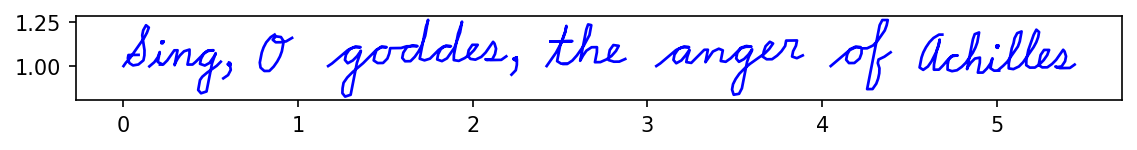

In [4]:
text = """Sing, O goddess, the anger of Achilles"""# son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled."""
word_list=text.split()

params = GenerationParams()
params.seed = 0

word_list_offsets = generate_paragraph(model, test_dataset, text, params)
sentence_points = word_offsets_to_points(word_list_offsets, params, word_list=word_list)
point_samp = np.vstack(sentence_points)

fig, ax = plot_strokes(point_samp, '',figsize=(9, 3*2), dpi=150)

## Now let's generate a whole paragraph

And use the regenerate feature to fix any mis-spellings

Generating...
    Sing, O (warmup_sample_ix=44)
    goddess, the (warmup_sample_ix=2933)
    anger of (warmup_sample_ix=1963)
    Achilles son (warmup_sample_ix=427)
    of Peleus, (warmup_sample_ix=2497)
    that brought (warmup_sample_ix=101)
    countless ills (warmup_sample_ix=756)
    upon the (warmup_sample_ix=2878)
    Achaeans. Many (warmup_sample_ix=1056)
    a brave (warmup_sample_ix=794)
    soul did (warmup_sample_ix=2126)
    it send (warmup_sample_ix=1391)
    hurrying down (warmup_sample_ix=824)
    to Hades, (warmup_sample_ix=2269)
    and many (warmup_sample_ix=549)
    a hero (warmup_sample_ix=481)
    did it (warmup_sample_ix=2363)
    yield a (warmup_sample_ix=2995)
    prey to (warmup_sample_ix=1822)
    dogs and (warmup_sample_ix=2711)
    vultures, for (warmup_sample_ix=1778)
    so were (warmup_sample_ix=2896)
    the counsels (warmup_sample_ix=1771)
    of Jove (warmup_sample_ix=283)
    fulfilled. (warmup_sample_ix=782)


(<Figure size 2400x1600 with 1 Axes>, <Axes: >)

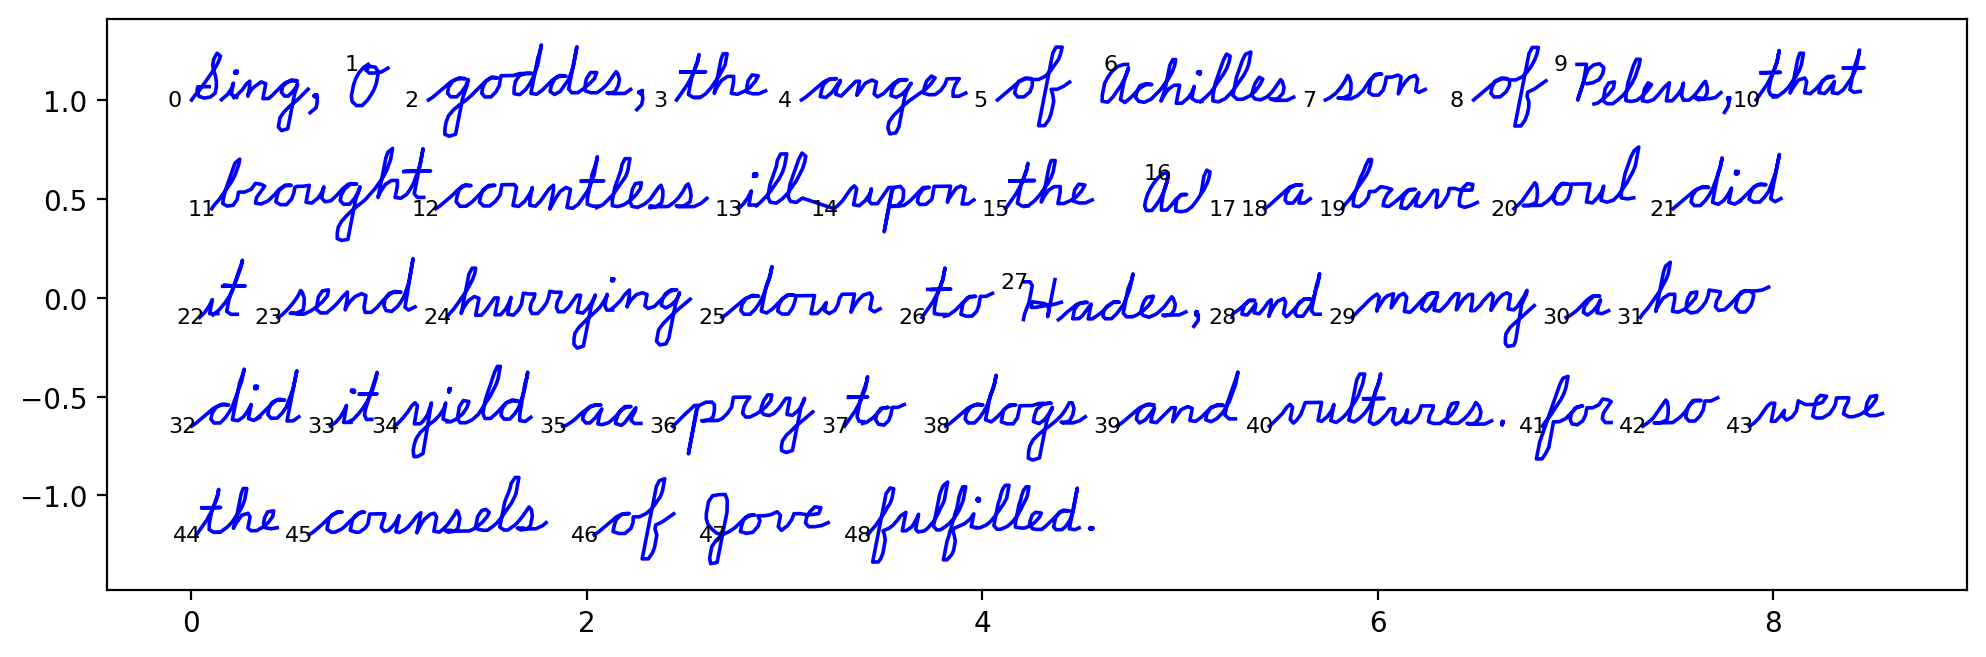

In [5]:
text = """Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled."""
word_list = text.split()
params = GenerationParams()
params.seed = 0

word_list_offsets = generate_paragraph(model, test_dataset, text, params)
plot_paragraph(word_list_offsets, text=text, params=params, show_indices=True)

Regenerating words at indices: [2, 6, 9, 12, 17, 34, 40]
    goddess, (warmup_sample_ix=2845)
    Achilles (warmup_sample_ix=368)
    Peleus, (warmup_sample_ix=491)
    countless (warmup_sample_ix=432)
    Many (warmup_sample_ix=1516)
    yield (warmup_sample_ix=2340)
    vultures, (warmup_sample_ix=242)


(<Figure size 2400x1600 with 1 Axes>, <Axes: >)

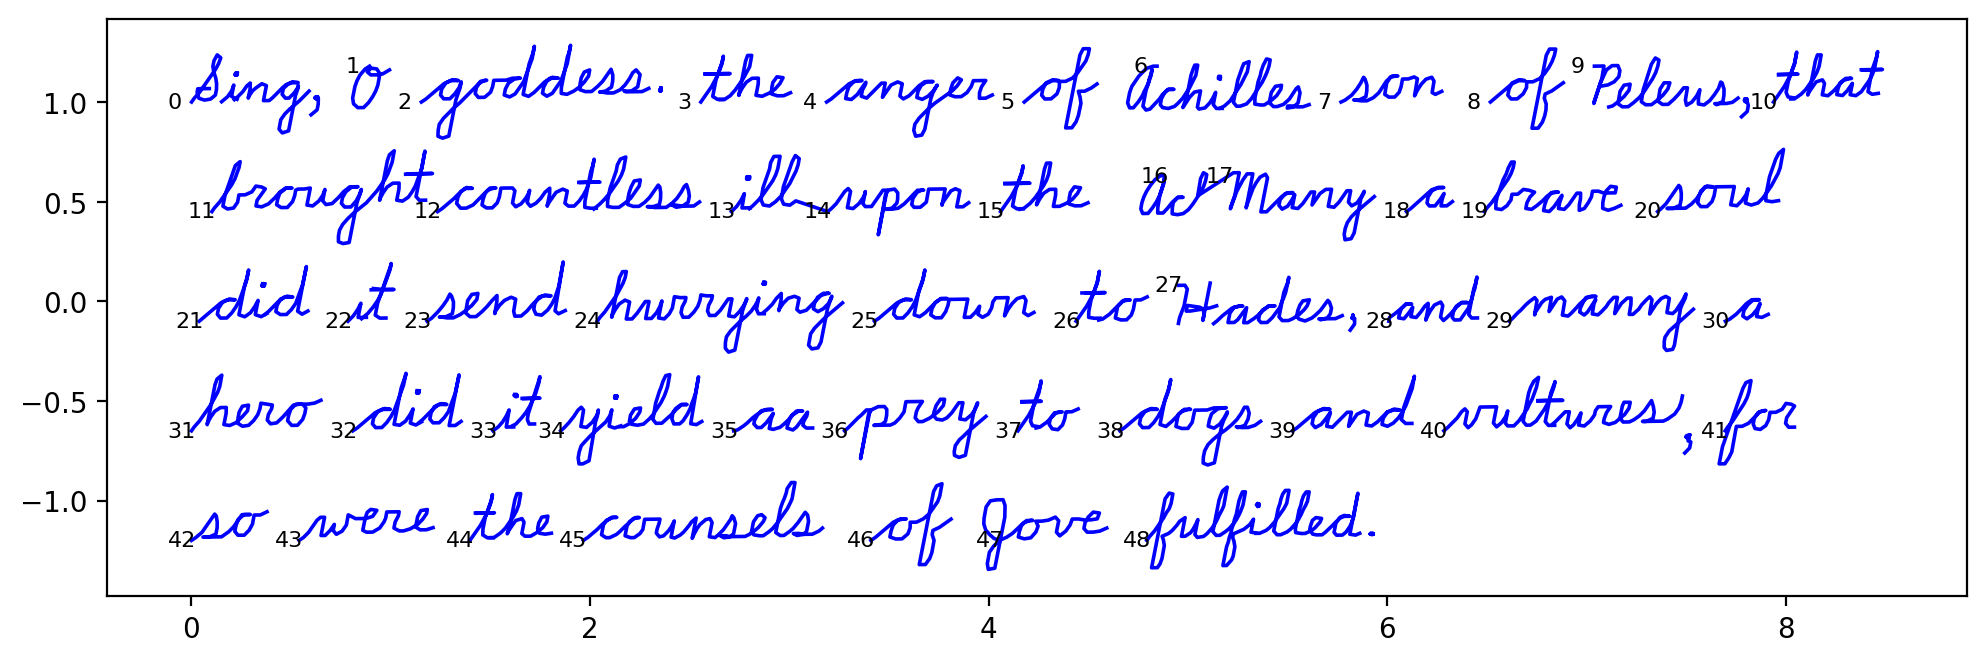

In [6]:
params.seed = 1
word_list_offsets = generate_paragraph(model, test_dataset, text, params, word_list_offsets,
                                       regenerate_ixs=[2,6,9,12,17,34,40])
plot_paragraph(word_list_offsets, text=text, params=params, show_indices=True)

Regenerating words at indices: [13]
    ills (warmup_sample_ix=1848)


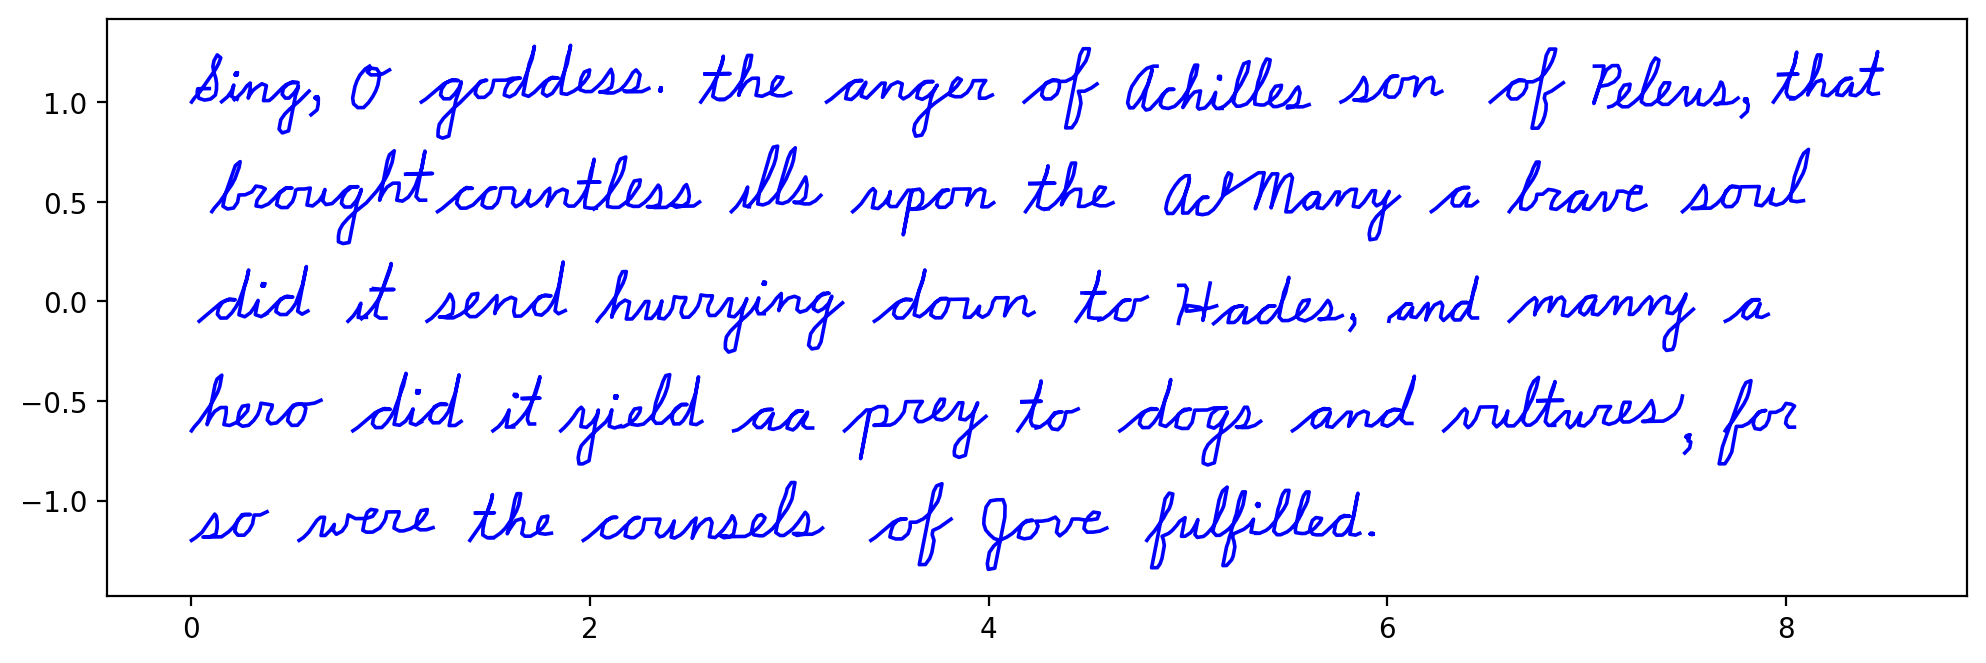

In [9]:
# change a couple of the other parameters to improve the appearance of the plotted strokes
params.seed = 2
params.sentence_line_height = 0.55
params.sentence_line_width = 8
params.space_width = 0.16

word_list_offsets = generate_paragraph(model, test_dataset, text, params, word_list_offsets,
                                       regenerate_ixs=[13])
plot_paragraph(word_list_offsets, text=text, params=params, show_indices=False)
plt.show()

## Visualizing Attention Patterns
The first two cells will just involve creating helper functions for logging attention patterns and plotting.

In [53]:
def set_up_attention_hooks(model):
    self_attn_patterns = {i: {} for i in range(len(model.transformer.h))}
    cross_attn_patterns = {i: {} for i in range(len(model.transformer.h))}

    def self_attn_hook(mod, inp, out):
        x = inp[0]
        q, k, v = mod.c_attn(x).split(mod.n_embd, dim=2)
        B, T, C = q.size()

        k = k.view(B, T, mod.n_head, C // mod.n_head).transpose(1, 2)
        q = q.view(B, T, mod.n_head, C // mod.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(mod.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        layer_idx = next(i for i, layer in enumerate(model.transformer.h) if layer.attn == mod)
        self_attn_patterns[layer_idx][mod] = att.detach()

        return out

    def cross_attn_hook(mod, inp, out):
        x, context = inp
        B, T, C = x.size()
        _, T_ctx, _ = context.size()

        q = mod.c_attn_q(x).view(B, T, mod.n_ctx_head, C // mod.n_ctx_head).transpose(1, 2)
        k, v = mod.c_attn_kv(context).split(mod.n_embd_context, dim=2)
        k = k.view(B, T_ctx, mod.n_ctx_head, C // mod.n_ctx_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)

        layer_idx = next(i for i, layer in enumerate(model.transformer.h) if layer.cross_attn == mod)
        cross_attn_patterns[layer_idx][mod] = att.detach()

        return out

    return self_attn_patterns, cross_attn_patterns, self_attn_hook, cross_attn_hook

In [54]:
def capture_and_plot_attention(model, dataset, text, output_dir=None):
    params = GenerationParams()
    params.temperature = 0.5
    params.do_sample = True
    params.num_steps = 1500
    print('Assuming this model was trained on {}-word seqs'.format(params.n_words))
    # params.n_words = 4 #len(text.split())

    patterns, cross_patterns, self_hook, cross_hook = set_up_attention_hooks(model)

    hooks = []
    for layer in model.transformer.h:
        hooks.extend([
            layer.attn.register_forward_hook(self_hook),
            layer.cross_attn.register_forward_hook(cross_hook)])

    try:
        with torch.no_grad():
            word_list = text.strip().split()
            ascii_context, generated_word_offsets =\
                   generate_helper_fn(model, dataset, word_list, params)
    finally:
        for hook in hooks:
            hook.remove()

    return ascii_context, generated_word_offsets, patterns, cross_patterns

In [63]:
def plot_self_attention(patterns, layer_idx=1, head_idx=1, max_stroke_ix=120, figsize=(9, 8), dpi=DPI, stride=1):
    plt.rcParams.update({
        'font.family': 'serif', 'font.size': 18,
        'axes.labelsize': 22, 'axes.titlesize': 24,
        'xtick.labelsize': 20, 'ytick.labelsize': 20 })

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    self_attn = next(iter(patterns[layer_idx].values())).squeeze(0).detach().cpu().numpy()
    # Apply stride to reduce checkerboard patterns
    display_attn = self_attn[head_idx][:max_stroke_ix,:max_stroke_ix][1::stride,1::stride]

    sns.heatmap(display_attn, ax=ax, cmap="YlOrRd", vmin=0, vmax=1.0,
        cbar_kws={'label': 'Self-Attention Weight'}, rasterized=True)

    ax.collections[0].set_clim(0, 1)

    grid_interval = max(1, display_attn.shape[0] // 20)
    for i in range(0, display_attn.shape[0] + 1, grid_interval):
        ax.axvline(x=i, color='white', linewidth=0.5, alpha=0.5, zorder=5)
        ax.axhline(y=i, color='white', linewidth=0.5, alpha=0.5, zorder=5)

    ax.set_xlabel("Source stroke token index", labelpad=15)
    ax.set_ylabel("Target stroke token index", labelpad=15)

    num_ticks = 6
    positions = np.linspace(0, display_attn.shape[0], num_ticks, endpoint=False).astype(int)

    # Convert display positions back to original indices
    original_positions = [pos * stride for pos in positions]
    labels = [str(pos) for pos in original_positions]

    ax.set_yticks(positions) ; ax.set_yticklabels(labels)
    ax.set_xticks(positions) ; ax.set_xticklabels(labels)

    # Add note about stride if not 1
    if stride > 1:
        ax.set_title(f"Stride = {stride} (showing every {stride}nd token)", fontsize=18)

    ax.tick_params(axis='both', which='both', length=4, width=1)
    plt.tight_layout(pad=2.0)
    return fig

## Self-attention plots
Ok, now we are ready to do a forward pass of the model, generate some text, log attention patterns, and then make some plots. Let's begin by plotting the self-attention patterns for all heads and layers.

Assuming this model was trained on 4-word seqs
 (warmup_sample_ix=1937)
(oaddzn the anger of Achilles


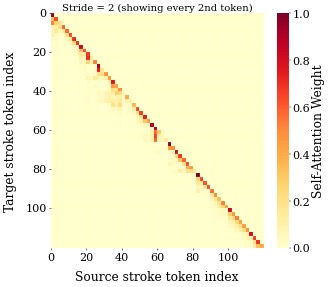

In [70]:
plt.rcParams.update({
  'font.family': 'serif', 'font.size': 11, 'axes.labelsize': 12,
  'axes.titlesize': 13, 'figure.titlesize': 14})

np.random.seed(10)
torch.manual_seed(10)  # system inits
torch.cuda.manual_seed_all(10)
DPI = 40  # set to 150 when plotting for the paper


text = 'the anger of Achilles'
ascii_context, generated_word_offsets, patterns, cross_patterns = \
   capture_and_plot_attention(model, test_dataset, text, output_dir=None)
print(ascii_context)

os.makedirs('plots/self_attn', exist_ok=True)
layer_idx = 3
head_idx = 2

# Use stride=2 to show only every other index (even or odd)
fig = plot_self_attention(patterns, layer_idx, head_idx, stride=2, dpi=DPI)
plt.show()

<ipython-input-63-fe052026617f>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize, dpi=dpi)


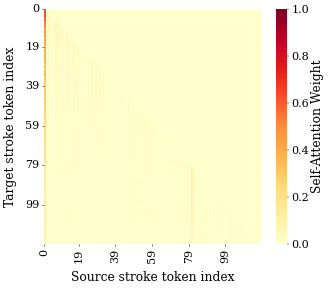

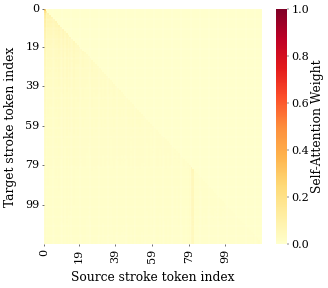

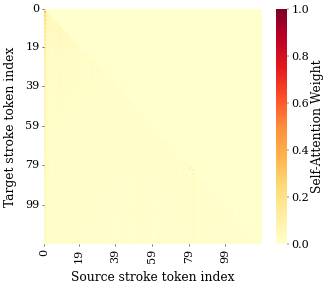

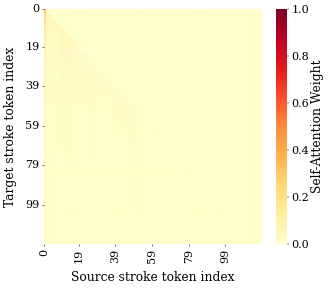

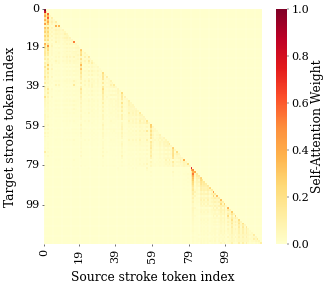

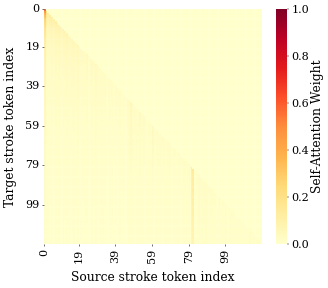

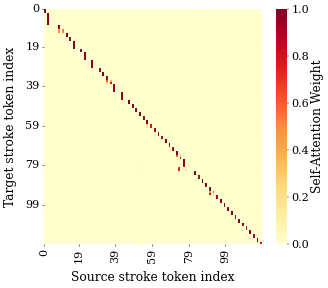

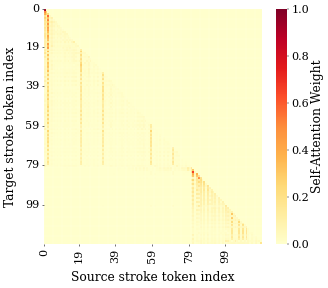

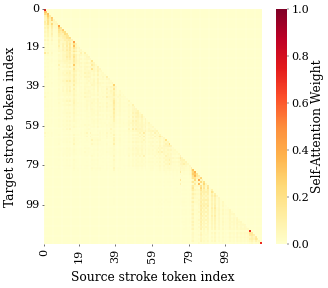

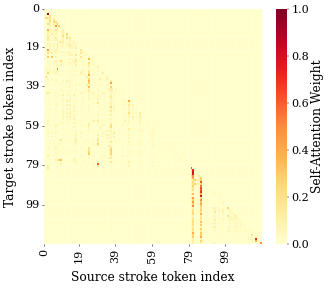

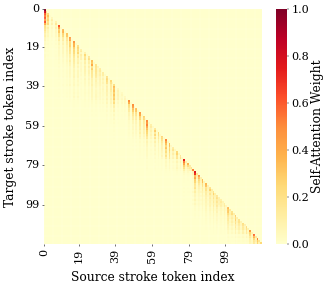

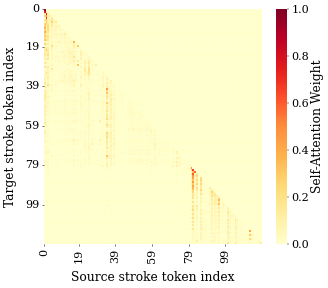

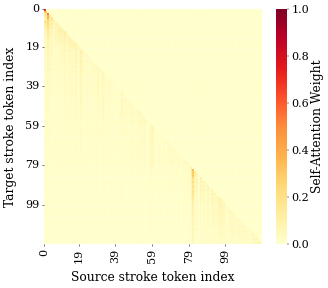

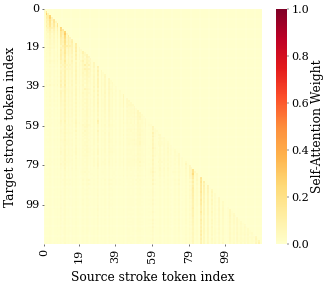

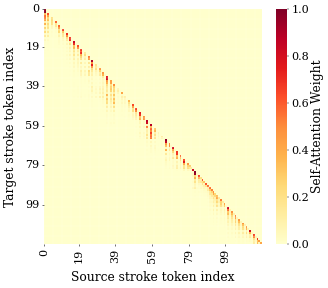

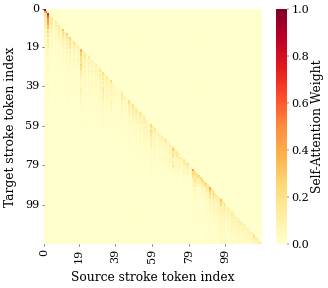

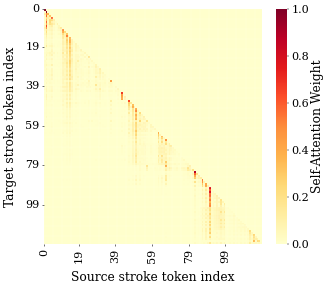

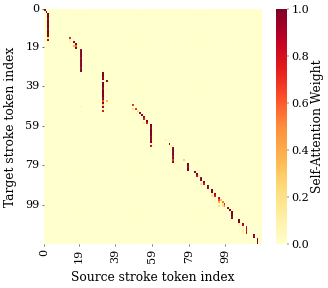

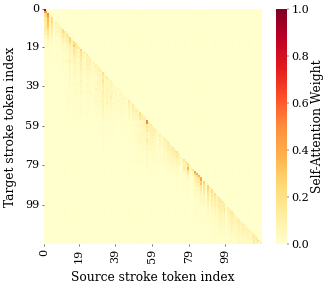

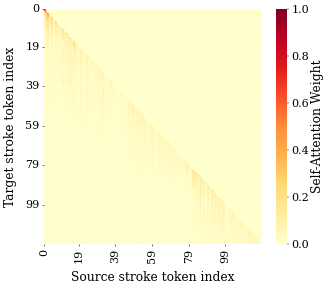

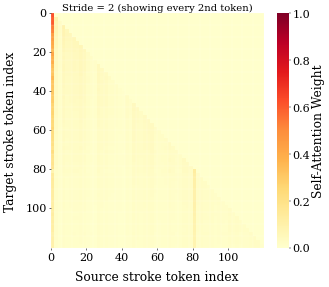

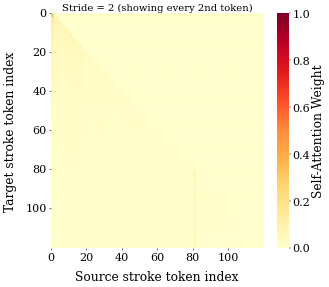

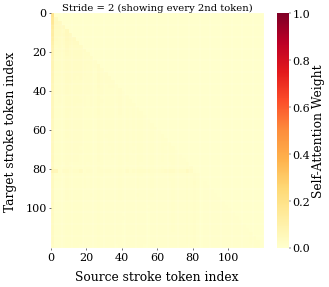

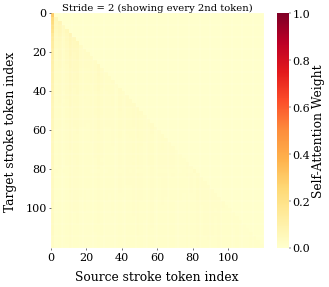

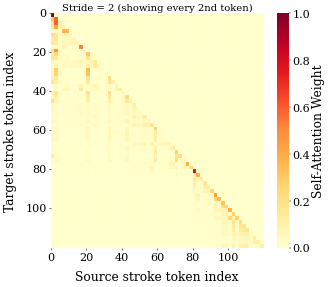

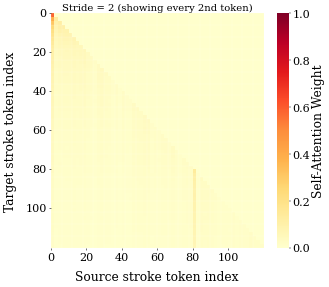

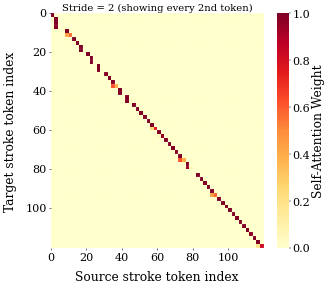

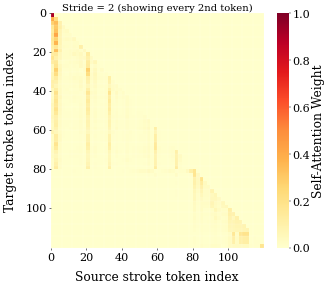

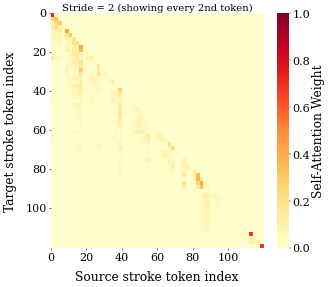

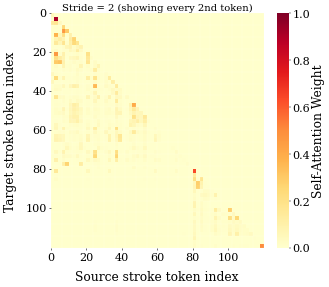

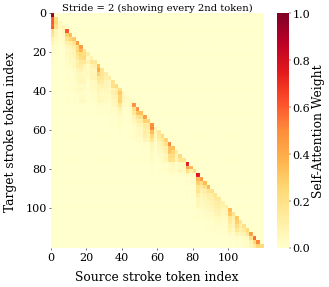

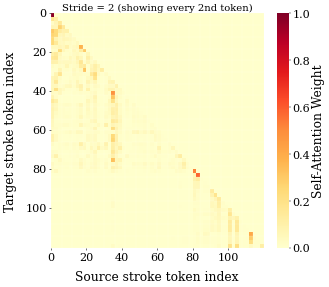

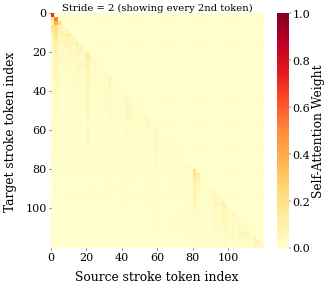

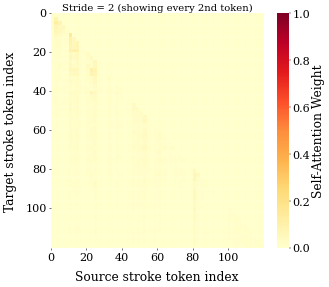

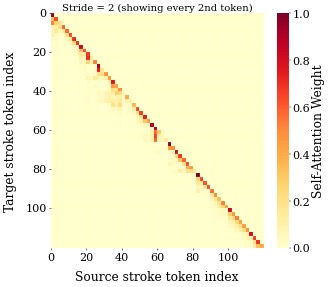

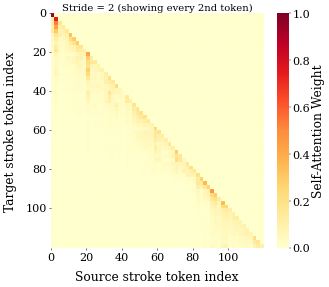

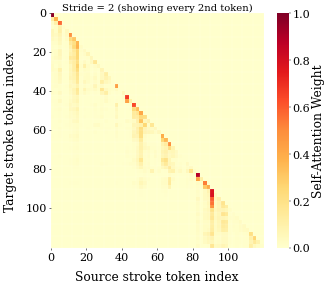

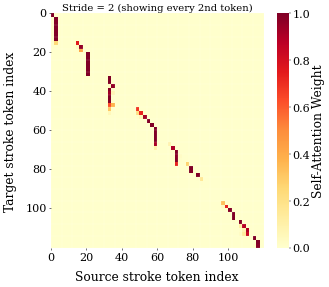

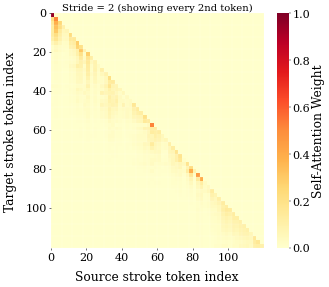

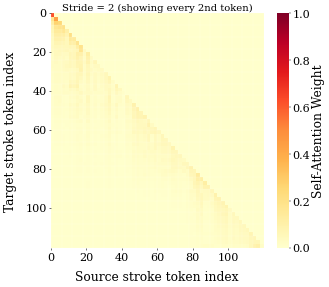

In [71]:
os.makedirs('plots/self_attn', exist_ok=True)

for stride in [1,2]:
  for layer_idx in range(args.n_layer):
    for head_idx in range(args.n_ctx_head):
      fig = plot_self_attention(patterns, layer_idx, head_idx, stride=stride, dpi=DPI)
      plt.savefig(f"plots/self_attn/stride{stride}_layer{layer_idx+1}_head{head_idx+1}.pdf", bbox_inches='tight')

## Cross-attention plots
Ok, now we are ready to plot an even more interesting set of plots -- the cross attention plots. These reveal how the model is thinking about the ASCII context information as it uses the pen to draw those characters.

In [73]:
def plot_cross_attention(text, cross_patterns, layer_idx=1, head_idx=1, figsize=(9, 8), dpi=150, drop_warmup=True):
    plt.rcParams.update({
        'font.family': 'serif', 'font.size': 18,
        'axes.labelsize': 22, 'axes.titlesize': 24,
        'xtick.labelsize': 20, 'ytick.labelsize': 20 })

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cross_attn = next(iter(cross_patterns[layer_idx].values())).squeeze(0).detach().cpu().numpy()

    first_space_idx = text.find(' ')
    if drop_warmup and first_space_idx != -1:
      display_text = text[first_space_idx+1:]
      last_char_ix = len(display_text)
      display_attn = cross_attn[head_idx][:, first_space_idx+1:last_char_ix]
    else:
      display_text = text
      last_char_ix = len(display_text)
      display_attn = cross_attn[head_idx][...,:last_char_ix]

    sns.heatmap(display_attn, ax=ax, cmap="YlGnBu", vmin=0, vmax=1.0,
        cbar_kws={'label': 'Cross-Attention Weight'}, rasterized=True)

    ax.collections[0].set_clim(0, 1)
    for i in range(len(display_text) + 1):
        ax.axvline(x=i, color='k', linewidth=0.5, alpha=0.7, zorder=5)

    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(np.arange(len(display_text)) + 0.5)
    ax_top.set_xticklabels(list(display_text), rotation=0, ha='center', fontsize=20, fontweight='bold')
    ax_top.tick_params(axis='x', length=4, width=1, direction='out')

    ax.set_xlabel("ASCII token index", labelpad=15)
    ax.set_ylabel("Stroke token index", labelpad=15)

    num_y_ticks = 6
    y_positions = np.linspace(0, display_attn.shape[0], num_y_ticks, endpoint=False).astype(int)
    y_labels = [str(pos) for pos in y_positions]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)

    num_x_ticks = min(8, display_attn.shape[1])
    x_positions = np.linspace(0, display_attn.shape[1], num_x_ticks, endpoint=False).astype(int)
    ax.set_xticks(x_positions + 0.5)
    ax.set_xticklabels([str(pos) for pos in x_positions])

    ax.tick_params(axis='both', which='both', length=4, width=1)

    plt.tight_layout(pad=2.0)
    return fig

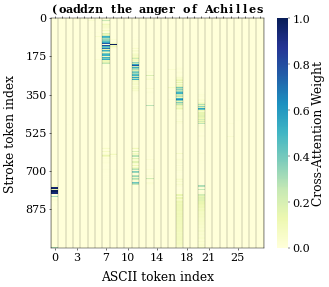

In [74]:
os.makedirs('plots/cross_attn', exist_ok=True)

layer_idx = 4
head_idx = 3
fig = plot_cross_attention(ascii_context, cross_patterns, layer_idx, head_idx, drop_warmup=False, dpi=DPI)
plt.show()

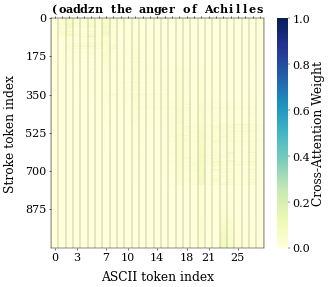

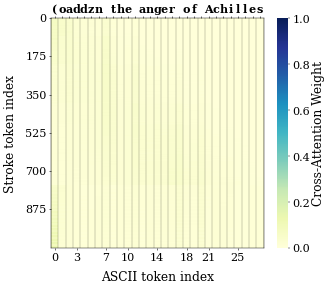

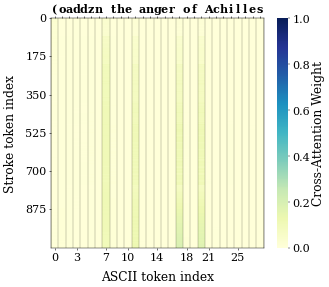

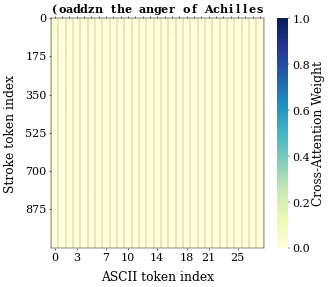

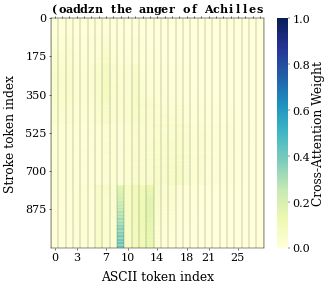

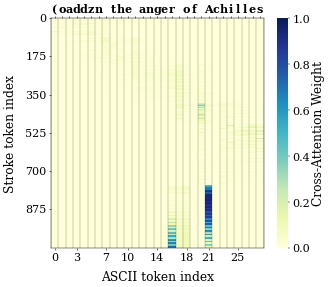

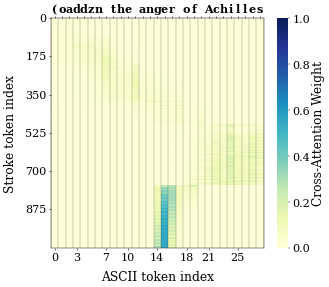

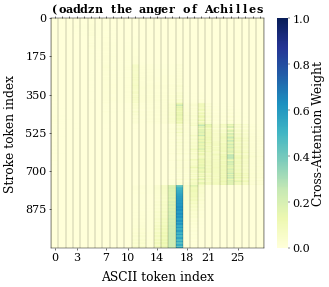

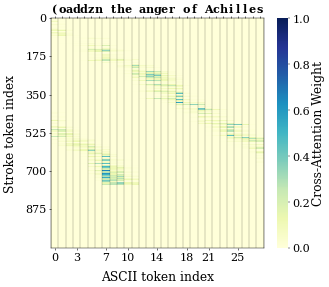

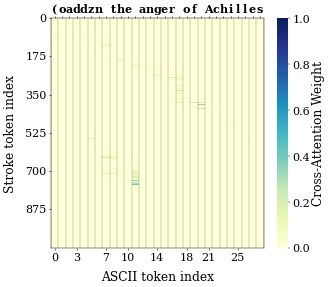

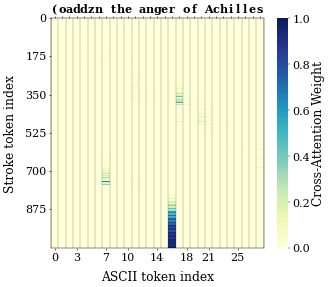

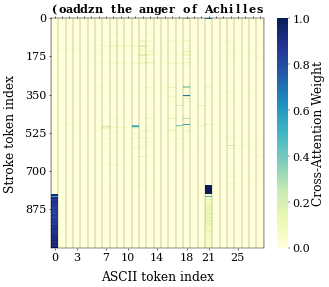

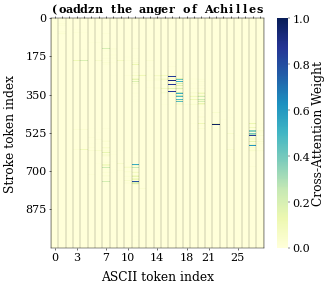

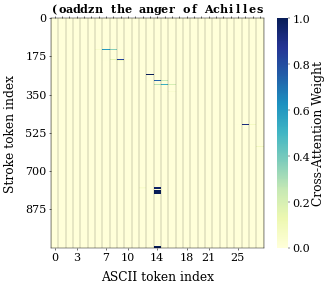

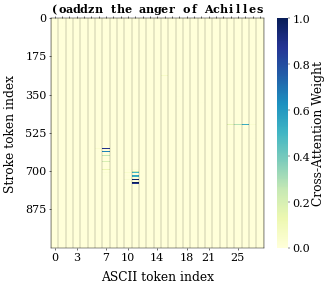

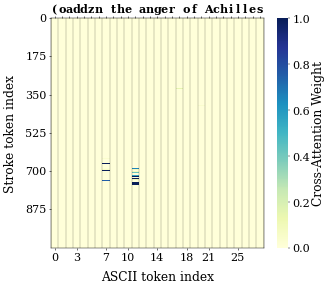

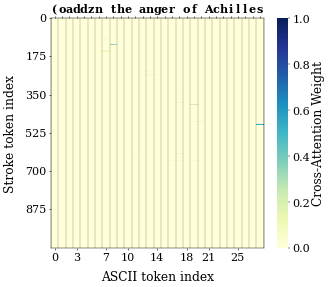

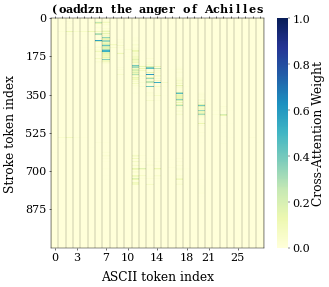

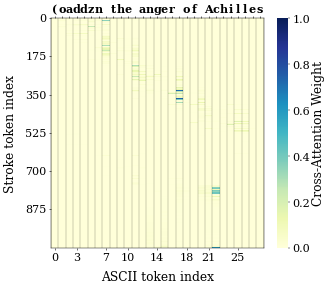

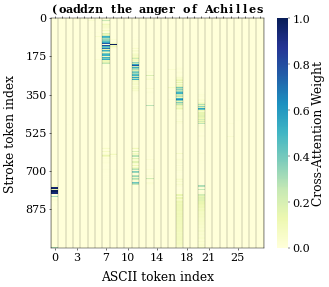

In [83]:
os.makedirs('plots/cross_attn', exist_ok=True)

for layer_idx in range(args.n_layer):
  for head_idx in range(args.n_ctx_head):
    fig = plot_cross_attention(ascii_context, cross_patterns, layer_idx, head_idx, drop_warmup=False, dpi=DPI)
    plt.savefig(f"plots/cross_attn/layer{layer_idx+1}_head{head_idx+1}.pdf", bbox_inches='tight')

## Fancy plotting mode for pen strokes

This new section is experimental. The idea is to clean up the pen stroke data -- smooth it in an intelligent manner -- and change parameters like line color and width to get a better sample.

In [84]:
def clean_up_strokes(stroke_points, window_length=4, polyorder=2):
    if len(stroke_points) < window_length:
        return stroke_points

    points = np.array(stroke_points)
    strokes = []
    current_stroke = []

    for i, point in enumerate(points):
        if i > 0 and points[i-1][2] != point[2]:  # Pen state changed
            if current_stroke:
                strokes.append(np.array(current_stroke))
                current_stroke = []
        current_stroke.append(point)
    if current_stroke:
        strokes.append(np.array(current_stroke))

    cleaned_strokes = []
    for stroke in strokes:
        if len(stroke) > window_length:
            x_smooth = savgol_filter(stroke[:, 0], window_length, polyorder)
            y_smooth = savgol_filter(stroke[:, 1], window_length, polyorder)
            cleaned_points = np.column_stack((x_smooth, y_smooth, stroke[:, 2]))
            cleaned_strokes.extend(cleaned_points)
        else:
            cleaned_strokes.extend(stroke)

    return np.array(cleaned_strokes)


def plot_strokes(stroke, title, fig=None, ax=None, figsize=(12, 2),
                 dpi=150, connect=True, **kwargs):
    """Plot a single stroke"""
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    stroke = clean_up_strokes(stroke)

    # Separate strokes based on pen lifts
    strokes = []
    current_stroke = []
    for point in stroke:
        if point[2] == 1:  # Pen is down
            current_stroke.append(point)
        else:  # Pen is up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
    if current_stroke:
        strokes.append(current_stroke)

    # Plot each stroke
    for stroke in strokes:
        x, y = zip(*[(p[0], 1 - p[1]) for p in stroke])  # Invert y-axis
        if connect:
          ax.plot(x, y, 'k-', **kwargs)
        else:
          ax.plot(x, y, '.', color='k', **kwargs)

    ax.set_aspect('equal') ; ax.set_title(title)
    if fig is None: plt.show()
    return fig, ax

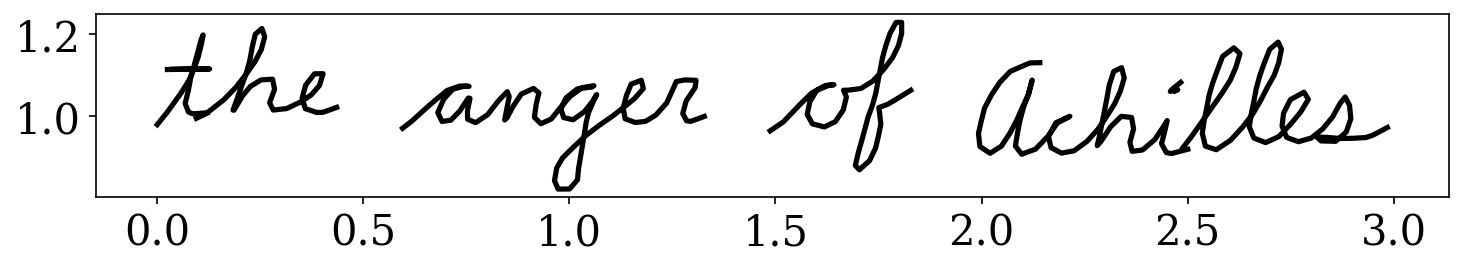

In [85]:
generated_points = word_offsets_to_points(generated_word_offsets, params)

_ = plot_strokes(np.vstack(generated_points), "", linewidth=2.5)
plt.tight_layout()
plt.savefig(f"plots/writing.pdf", bbox_inches='tight')